# Spatial Data Processing
### in Python, using geopandas

There are many ways to interact with spatial data - ranging from getting geometric points from addresses, to intersecting a different spatial datasets. In this workshop, we'll cover a number of methods using `geopandas`. However, this is just a specific instantiation of these ideas; they can also be done in GIS software.

In [1]:
import pandas as pd
import geopandas as gpd

Let's remind ourselves of some key concepts to start with.

First, there are two major types of spatial data.
 - Vector data represents geographic features as discrete points, lines, and polygons, making it ideal for boundaries, roads, or point locations like cities.
 - Raster data stores information in a grid of pixels (cells), often used for continuous data like elevation models or satellite imagery.

We also consider three common types of geometry.
 1. Points are zero-dimensional coordinates (e.g., a library’s latitude/longitude).
 2. Lines are one-dimensional sequences of points (e.g., rivers, roads, or transit routes).
 3. Polygons are two-dimensional enclosed shapes (e.g., political boundaries, lakes, or census tracts).

These can be projected into different Coordinate Reference Systems (CRS), which define how spatial data maps to the Earth’s surface. For example, WGS84 (EPSG:4326) is common for global latitude/longitude coordinates, while UTM zones (e.g., EPSG:32617) minimize distortion for local measurements. Choosing the right CRS ensures accurate distances, areas, and spatial relationships.

In order to process spatial data we will be working with three datasets today:
 - Toronto Public Libraries (TPL) branches, which contains information about each of the libraries in the TPL
 - Toronto's wards, each of which have a city councillor
 - Toronto's regions, which are the former municipalities that were amalgamated in 1998 to make modern Toronto

In [145]:
df_tpl = pd.read_csv('./data/tpl-branch-general-information-2023.csv')
gdf_wards = gpd.read_file('./data/city-wards.gpkg')
gdf_regions = gpd.read_file('./data/toronto-regions.gpkg')

## Geocoding and Creating Geometries

### Geocoding Addresses

Geocoding converts addresses (like `"100 Queen St, Toronto, ON M5H 2N2"`) into geographic coordinates (latitude/longitude) using a geocoding service. In GeoPandas, the `geopandas.tools.geocode()` method leverages the [Nominatim](https://nominatim.org/) geocoder by default, which queries OpenStreetMap’s database. This transforms a DataFrame of addresses into a GeoDataFrame with `Point` geometries, enabling spatial analysis.

Free geocoding services usually allow about one query per second - since we have over 100 library branches, this should take a few minutes

In [19]:
gdf_tpl = gpd.tools.geocode(
    df_tpl["Address"],  
    provider="nominatim",      
    user_agent="tpl-workshop",
    timeout=10
)

100%|█████████████████████████████████████| 112/112 [00:00<00:00, 114576.11it/s]


In [112]:
# In case the above takes too long
# gdf_tpl = gpd.read_file('./data/tpl.gpkg')

In [148]:
gdf_tpl

,geometry,address
0,POINT (613956.686 4843954.713),"Toronto Public Library - Albion, 1515, Albion ..."
1,POINT (639436.969 4840903.999),"Toronto Public Library - Albert Campbell, 496,..."
2,POINT (617250.270 4828684.997),"Alderwood Pool, 2, Orianna Drive, Alderwood, E..."
3,POINT (637314.699 4849438.607),"Toronto Public Library - Agincourt, 155, Bonis..."
4,POINT (627091.776 4844124.918),"Toronto Public Library - Armour Heights, 2140,..."
...,...,...
107,POINT (617698.730 4844001.503),"Toronto Public Library - Woodview Park, 16, Br..."
108,POINT (639171.567 4852212.822),Tickets & More Post Office (Woodside Square Ca...
109,POINT (627543.864 4837797.125),"Toronto Public Library - Wychwood, 1431, Bathu..."
110,POINT (629901.096 4836706.001),"Toronto Public Library - Yorkville, 22, Yorkvi..."


### Creating New Geometries

There's a number of basic operations we can do on spatial data.

First, we need to project this into a CRS which is measured in meters. If we used a longitude-latitude based measure like WGS84 (EPSG:4326), then we would end up with something in degrees - which is nonsense here.

In [149]:
gdf_wards = gdf_wards.to_crs("EPSG:32617")  # UTM Zone 17N (meters)  

Area: Calculates the area of polygon geometries using `.area` (returns values in CRS units, e.g., m² for projected CRS). 

In [150]:
# Calculate area (in m², then divide by 10^6 for km²)  
gdf_wards["area_km2"] = gdf_wards.area / 1e6  

gdf_wards[['WARD_NAME', 'area_km2']]

,WARD_NAME,area_km2
0,Humber River-Black Creek,30.694207
1,York Centre,35.352673
2,Willowdale,19.758824
3,University-Rosedale,13.594704
4,Beaches-East York,16.801757
5,Scarborough Southwest,28.187890
6,Scarborough-Rouge Park,54.085106
7,Scarborough North,30.433949
8,Scarborough-Guildwood,26.114731
9,Scarborough Centre,28.201837


Centroid: Computes the geometric center point of polygons using `.centroid` (returns a Point geometry for each feature). 

A simple application is using these centroids to then compute the distance from one to the other.

<Axes: >

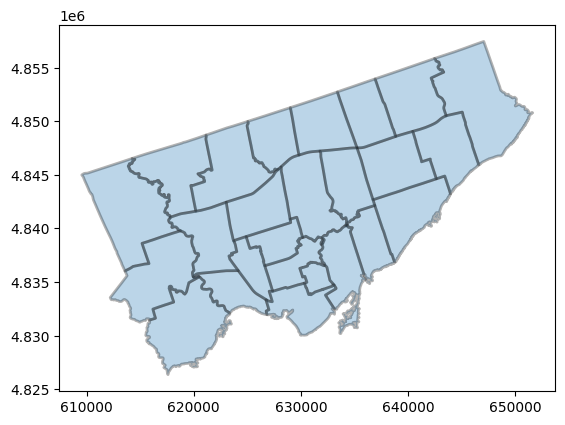

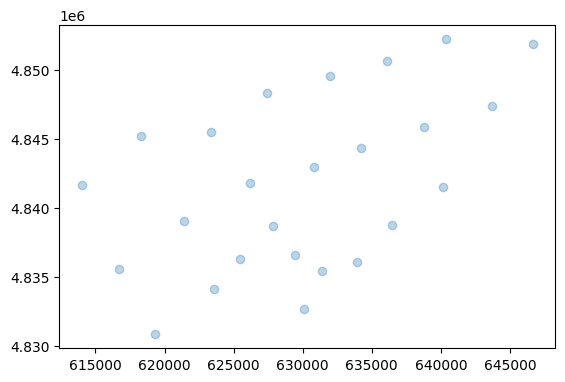

In [151]:
# Compute centroids (as Point geometries)  
gdf_wards["centroid"] = gdf_wards.centroid  

# Compare the wards and their center points
gdf_wards.plot(alpha=0.3, edgecolor='black', linewidth=2)  
gdf_wards.set_geometry("centroid").plot(alpha=0.3)  

Buffer: Creates a zone around geometries at a specified distance using `.buffer()` (distance units depend on CRS; e.g., meters for UTM).

In [152]:
# Create 500m buffers around each ward  
gdf_wards["buffer_500m"] = gdf_wards.buffer(500)  

<Axes: >

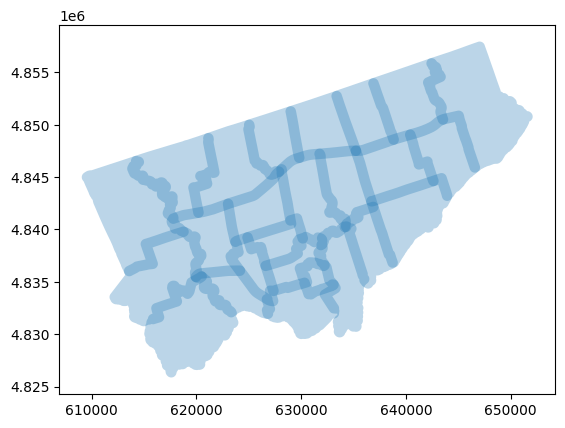

In [153]:
gdf_wards.set_geometry("buffer_500m").plot(alpha=0.3)  

## Spatial Relationships and Operations

Now that we've identified a few ways to create new spatial data, let's look at how we can understand the relationships between different sets of spatial data.

Before we compare any spatial data, it's important to make sure that they're all in the same CRS.

In [154]:
cur_crs = 4327
gdf_tpl = gdf_tpl.to_crs(cur_crs)
gdf_wards = gpd.read_file('./data/city-wards.gpkg').to_crs(cur_crs)
gdf_regions = gpd.read_file('./data/toronto-regions.gpkg').to_crs(cur_crs)

### Spatial Selection

Suppose we want to identify whether some geometry is inside of another. It depends on what kinds of geometry we're looking at and there's two methods to do that.
 - `.within()` checks if a geometry is *completely inside* another (e.g., "Is this library point within Scarborough's polygon?").
 - `.contains()` checks if a geometry *fully encloses* another (e.g., "Does Old Toronto's polygon contain this entire ward?").

In [155]:
# Get Scarborough's polygon from regions  
scarborough = gdf_regions[gdf_regions["REGION_NAME"] == "SCARBOROUGH"].geometry.iloc[0]  

# Filter libraries within Scarborough  
libraries_in_scarborough = gdf_tpl[gdf_tpl.within(scarborough)]  
print(f"{len(libraries_in_scarborough)} libraries in Scarborough")  

16 libraries in Scarborough


In [156]:
# Get Old Toronto's polygon from regions  
old_toronto = gdf_regions[gdf_regions["REGION_NAME"] == "TORONTO"].geometry.iloc[0]  

# Filter wards entirely within Old Toronto  
wards_in_toronto = gdf_wards[old_toronto.contains(gdf_wards.geometry)]
print(f"{len(wards_in_toronto)} wards fully contained by Old Toronto")

1 wards fully contained by Old Toronto


If we investigate this manually in GIS software, you'll notice that one more ward (Spadina-Fort York) is also basically contained in Old Toronto. However, due to differences when the data was made, there's some fine details that lead to tiny pieces being outside of the bigger region and thus lead to that ward not being counted. It's important to make sure the data you're working with is precisely suited to the task you're doing.

The `.cx[]` indexer filters geometries using coordinate ranges ([minx:maxx, miny:maxy]), acting like a spatial "crop" without explicit polygon creation. It’s faster than geometric operations but limited to rectangular areas.

In [157]:
# Define bbox: Toronto's east/west bounds, Eglinton (south) to Steeles (north)  
bbox = gdf_tpl.total_bounds  # Get full extent [minx, miny, maxx, maxy]  
bbox[1] = 43.70  # Set miny ≈ Eglinton Ave (lat)  
bbox[3] = 43.84  # Set maxy ≈ Steeles Ave (lat)  

# Filter libraries in bbox  
libraries_north_of_eglinton = gdf_tpl.cx[bbox[0]:bbox[2], bbox[1]:bbox[3]]  
count = len(libraries_north_of_eglinton)  
print(f"{count} libraries north of Eglinton Ave")  

45 libraries north of Eglinton Ave


### Overlay Operations

Overlay operations allow us to understand the nature of the relationships between different spatial data. There are four approaches that we will consider.
 - `intersection`: Finds only overlapping areas between two layers (Example: Identify which wards intersect with Old Toronto and count them)
 - `union`: Merges geometries into a single combined shape (Example: Combine all wards intersecting Old Toronto and calculate their total area)
 - `symmetric_difference`: Shows areas that are in either layer but not both (Example: Highlight areas unique to either Old Toronto wards or North York region)
 - `difference`: Extracts parts of the first layer not covered by the second (Example: Isolate ward segments that extend beyond Old Toronto's boundaries)

The image below is adapted from the [full tutorial](https://geopandas.org/en/stable/docs/user_guide/set_operations.html) by geopandas on this topic which you can look at for more details.

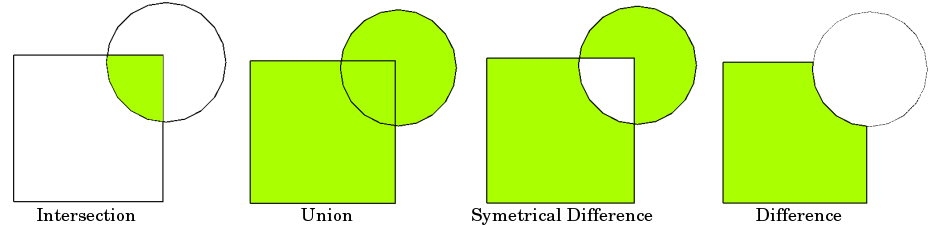!

In [158]:
cur_crs = 32617
gdf_tpl = gdf_tpl.to_crs(cur_crs)
gdf_wards = gpd.read_file('./data/city-wards.gpkg').to_crs(cur_crs)
gdf_regions = gpd.read_file('./data/toronto-regions.gpkg').to_crs(cur_crs)

#### Intersection: Find Wards Overlapping Old Toronto

In [161]:
# Get Old Toronto polygon
old_toronto = gdf_regions[gdf_regions["REGION_NAME"] == "TORONTO"]

# Find intersecting wards
intersection = gpd.overlay(gdf_wards, old_toronto, how="intersection", keep_geom_type=False)
print(f"{len(intersection['WARD_NAME'].unique())} wards overlap Old Toronto")

13 wards overlap Old Toronto


#### Union: Combine & Measure Intersecting Wards

Combined area: 263.42 km²


Text(0.5, 1.0, 'Wards Intersecting Old Toronto')

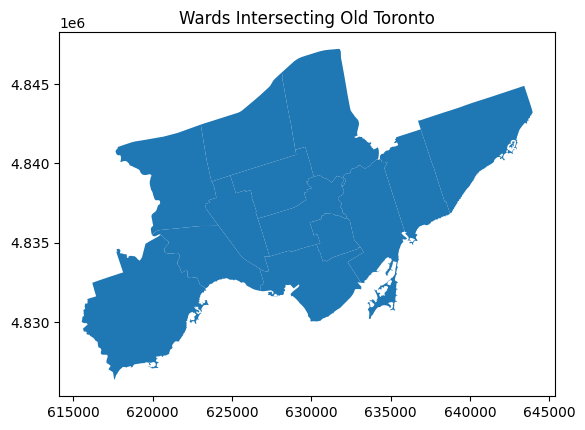

In [162]:
# Get intersecting wards
wards_in_toronto = gdf_wards[gdf_wards.intersects(old_toronto.unary_union)]

# Calculate combined area in km²
union_area = wards_in_toronto.area.sum() / 1e6
print(f"Combined area: {union_area:.2f} km²")

# Plot
ax = wards_in_toronto.plot()
ax.set_title("Wards Intersecting Old Toronto", fontsize=12)

#### Symmetric Difference: Unique Areas vs. North York

Text(0.5, 1.0, 'Areas Exclusive to Old Toronto Wards or North York')

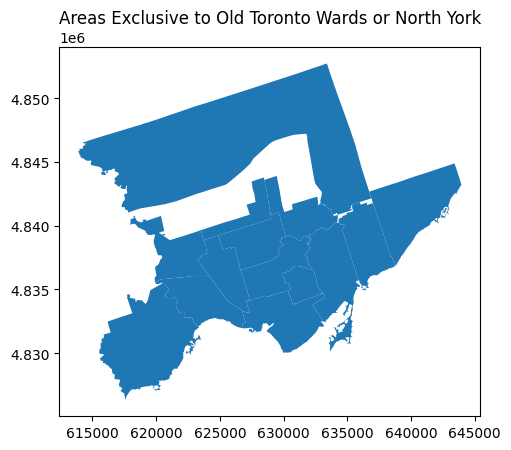

In [163]:
# Get North York polygon
north_york = gdf_regions[gdf_regions["REGION_NAME"] == "NORTH YORK"]

# Compare with Old Toronto wards -- basically, how much area these wards "eating" into North York?
sym_diff = gpd.overlay(wards_in_toronto, north_york, how="symmetric_difference")

# Plot
ax = sym_diff.plot()
ax.set_title("Areas Exclusive to Old Toronto Wards or North York", fontsize=12)

#### Difference: Ward Areas Outside Old Toronto

Text(0.5, 1.0, 'Old Toronto Ward Segments Outside Old Toronto')

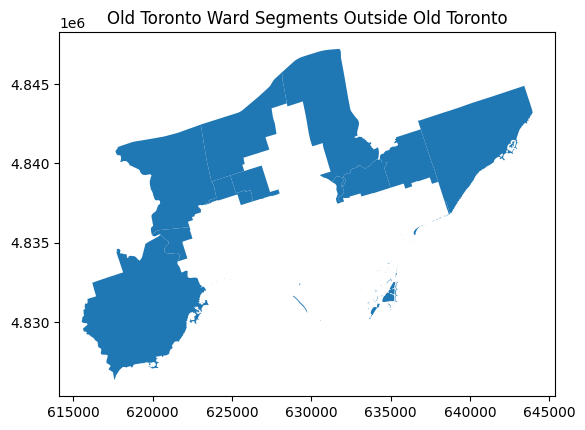

In [165]:
# Extract parts of wards beyond Old Toronto
difference = gpd.overlay(wards_in_toronto, old_toronto, how="difference")

# Plot
ax = difference.plot()
ax.set_title("Old Toronto Ward Segments Outside Old Toronto", fontsize=12)

### Spatial Joins

Spatial joins combine data from two GeoDataFrames based on their geometric relationship, allowing you to connect attributes from different layers. For example, you can match points (libraries) to polygons (wards) to see which administrative district contains each facility.

The `.sjoin()` method takes two key arguments:
 - `predicate='within'`: Matches features where the first layer is completely inside the second (e.g., libraries fully within a ward).
 - `predicate='intersects'`: Matches features that touch or overlap (e.g., wards that partially or fully overlap a region).

In [166]:
cur_crs = 32617
gdf_tpl = gdf_tpl.to_crs(cur_crs)
gdf_wards = gpd.read_file('./data/city-wards.gpkg').to_crs(cur_crs)
gdf_regions = gpd.read_file('./data/toronto-regions.gpkg').to_crs(cur_crs)

In [167]:
# Match wards to regions based on intersection  
wards_with_regions = gpd.sjoin(  
    gdf_wards,  
    gdf_regions,  
    how="left",  # Keep all wards even if no region match  
    predicate="intersects"  
)  

wards_with_regions

,WARD_SHORT_CODE,WARD_NAME,geometry,index_right,REGION_NAME
0,07,Humber River-Black Creek,"MULTIPOLYGON (((621458.592 4846712.482, 621544...",4,ETOBICOKE
0,07,Humber River-Black Creek,"MULTIPOLYGON (((621458.592 4846712.482, 621544...",1,NORTH YORK
1,06,York Centre,"MULTIPOLYGON (((625533.338 4846776.345, 625573...",1,NORTH YORK
2,18,Willowdale,"MULTIPOLYGON (((629235.325 4846644.348, 629226...",1,NORTH YORK
3,11,University-Rosedale,"MULTIPOLYGON (((629747.036 4838758.081, 629746...",5,TORONTO
3,11,University-Rosedale,"MULTIPOLYGON (((629747.036 4838758.081, 629746...",2,EAST YORK
4,19,Beaches-East York,"MULTIPOLYGON (((637056.976 4841642.218, 637080...",5,TORONTO
4,19,Beaches-East York,"MULTIPOLYGON (((637056.976 4841642.218, 637080...",2,EAST YORK
4,19,Beaches-East York,"MULTIPOLYGON (((637056.976 4841642.218, 637080...",1,NORTH YORK
4,19,Beaches-East York,"MULTIPOLYGON (((637056.976 4841642.218, 637080...",3,SCARBOROUGH


Notice something interesting has happened: most wards belong to multiple regions. Sometimes this is genuinely the case as a ward might be split across different regions, and other times there might just be a sliver that intersects due to inconsistent geometric coding. 

But ultimately we want to know which exact region we can put a ward in. One way to do this is to conduct a spatial join and filter for the region with which a ward has the highest intersection.

In [177]:
# Perform intersection and calculate overlap areas
intersections = gpd.overlay(
    gdf_wards[["WARD_NAME", "geometry"]],
    gdf_regions[["REGION_NAME", "geometry"]],
    how="intersection",
    keep_geom_type=True,
)
intersections["overlap_area"] = intersections.area  # Calculate area in m²

# Find the region with maximum overlap for each ward
dominant_regions = (
    intersections
    .sort_values("overlap_area", ascending=False)
    .drop_duplicates("WARD_NAME")
    [["WARD_NAME", "REGION_NAME", "overlap_area"]]
)

# Merge back with original wards data
wards_with_primary_region = gdf_wards.merge(
    dominant_regions,
    on="WARD_NAME",
    how="left"
)

# Show results
wards_with_primary_region[["WARD_NAME", "REGION_NAME", "overlap_area"]]

,WARD_NAME,REGION_NAME,overlap_area
0,Humber River-Black Creek,NORTH YORK,3.069420e+07
1,York Centre,NORTH YORK,3.535267e+07
2,Willowdale,NORTH YORK,1.975882e+07
3,University-Rosedale,TORONTO,1.298088e+07
4,Beaches-East York,TORONTO,8.270194e+06
5,Scarborough Southwest,SCARBOROUGH,2.805821e+07
6,Scarborough-Rouge Park,SCARBOROUGH,5.399644e+07
7,Scarborough North,SCARBOROUGH,3.043395e+07
8,Scarborough-Guildwood,SCARBOROUGH,2.604160e+07
9,Scarborough Centre,SCARBOROUGH,2.820184e+07
